In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from empiricaldist import Pmf, Cdf
from matplotlib.ticker import MaxNLocator
%matplotlib inline  
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# for one hot encoding with feature-engine
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
import scipy.stats as stats
from feature_engine import variable_transformers as vt
from sklearn.preprocessing import StandardScaler

In [42]:
train_data = pd.read_csv("train.csv")

In [43]:
# transform type

train_data[["MoSold", "MSSubClass"]] = train_data[["MoSold", "MSSubClass"]].astype(str)

In [44]:
# separate object and numerical columns. Separate area and surface area columns and year columns as wel

cat_cols = [x for x in train_data.columns if train_data[x].dtype==np.object]
num_cols = [x for x in train_data.columns if train_data[x].dtype!=np.object]
area_cols = [x for x in train_data.columns if ("SF" in x)|("Area" in x)|(x=="LotFrontage")]
year_cols = [x for x in num_cols if 'Yr' in x or 'Year' in x]

In [45]:
# for this models, let's drop all cat_cols and year_cols for now

train_data.drop(cat_cols+year_cols, axis=1, inplace=True)

In [46]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 32 columns):
Id               1460 non-null int64
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
MasVnrArea       1452 non-null float64
BsmtFinSF1       1460 non-null int64
BsmtFinSF2       1460 non-null int64
BsmtUnfSF        1460 non-null int64
TotalBsmtSF      1460 non-null int64
1stFlrSF         1460 non-null int64
2ndFlrSF         1460 non-null int64
LowQualFinSF     1460 non-null int64
GrLivArea        1460 non-null int64
BsmtFullBath     1460 non-null int64
BsmtHalfBath     1460 non-null int64
FullBath         1460 non-null int64
HalfBath         1460 non-null int64
BedroomAbvGr     1460 non-null int64
KitchenAbvGr     1460 non-null int64
TotRmsAbvGrd     1460 non-null int64
Fireplaces       1460 non-null int64
GarageCars       1460 non-null int64
GarageArea       1460 non-null int64
W

In [47]:
# percentages of missing data in the numerical cols

for col in train_data.columns:
    if train_data[col].isnull().sum() > 0:
        print(col, train_data[col].isnull().mean())

LotFrontage 0.1773972602739726
MasVnrArea 0.005479452054794521


In [48]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['Id', 'SalePrice'], axis=1),
                                                    train_data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 30), (146, 30))

In [49]:
# step1. Handle missing data. We will used a median approach since the distributions are skewed

# define an imputation function
def impute_na_median(df, cols):
    for col in cols:
        df[col]= df[col].fillna(df[col].median())
    
    return df

# apply on train set and test set
X_train_imp = impute_na_median(X_train, cols=['LotFrontage', 'MasVnrArea'])
X_test_imp = impute_na_median(X_test, cols=['LotFrontage', 'MasVnrArea'])

In [50]:
# check

for col in X_train_imp.columns:
    if X_train_imp[col].isnull().sum() > 0:
        print(col, X_train_imp[col].isnull().mean())

In [52]:
# step2. transform the area columns to enhance skew

yjt = vt.YeoJohnsonTransformer(variables = area_cols)
yjt.fit(X_train_imp)
print(yjt.lambda_dict_)
X_train_imp_tr = yjt.transform(X_train_imp)
X_test_imp_tr = yjt.transform(X_test_imp)

{'LotFrontage': 0.422432655023388, 'LotArea': -12.55283001172003, 'MasVnrArea': -0.25336100411247126, 'BsmtFinSF1': 0.2241603622191745, 'BsmtFinSF2': -1.5253670841536835, 'BsmtUnfSF': 0.4741451871581765, 'TotalBsmtSF': 0.7320141644679369, '1stFlrSF': -12.55283001172003, '2ndFlrSF': -0.12038141633304861, 'LowQualFinSF': -9.769635009367672, 'GrLivArea': 0.03602357773149543, 'GarageArea': 0.8072365473023602, 'WoodDeckSF': -0.08553433814930124, 'OpenPorchSF': 0.015647864654396017, 'PoolArea': -34.48045639184592}


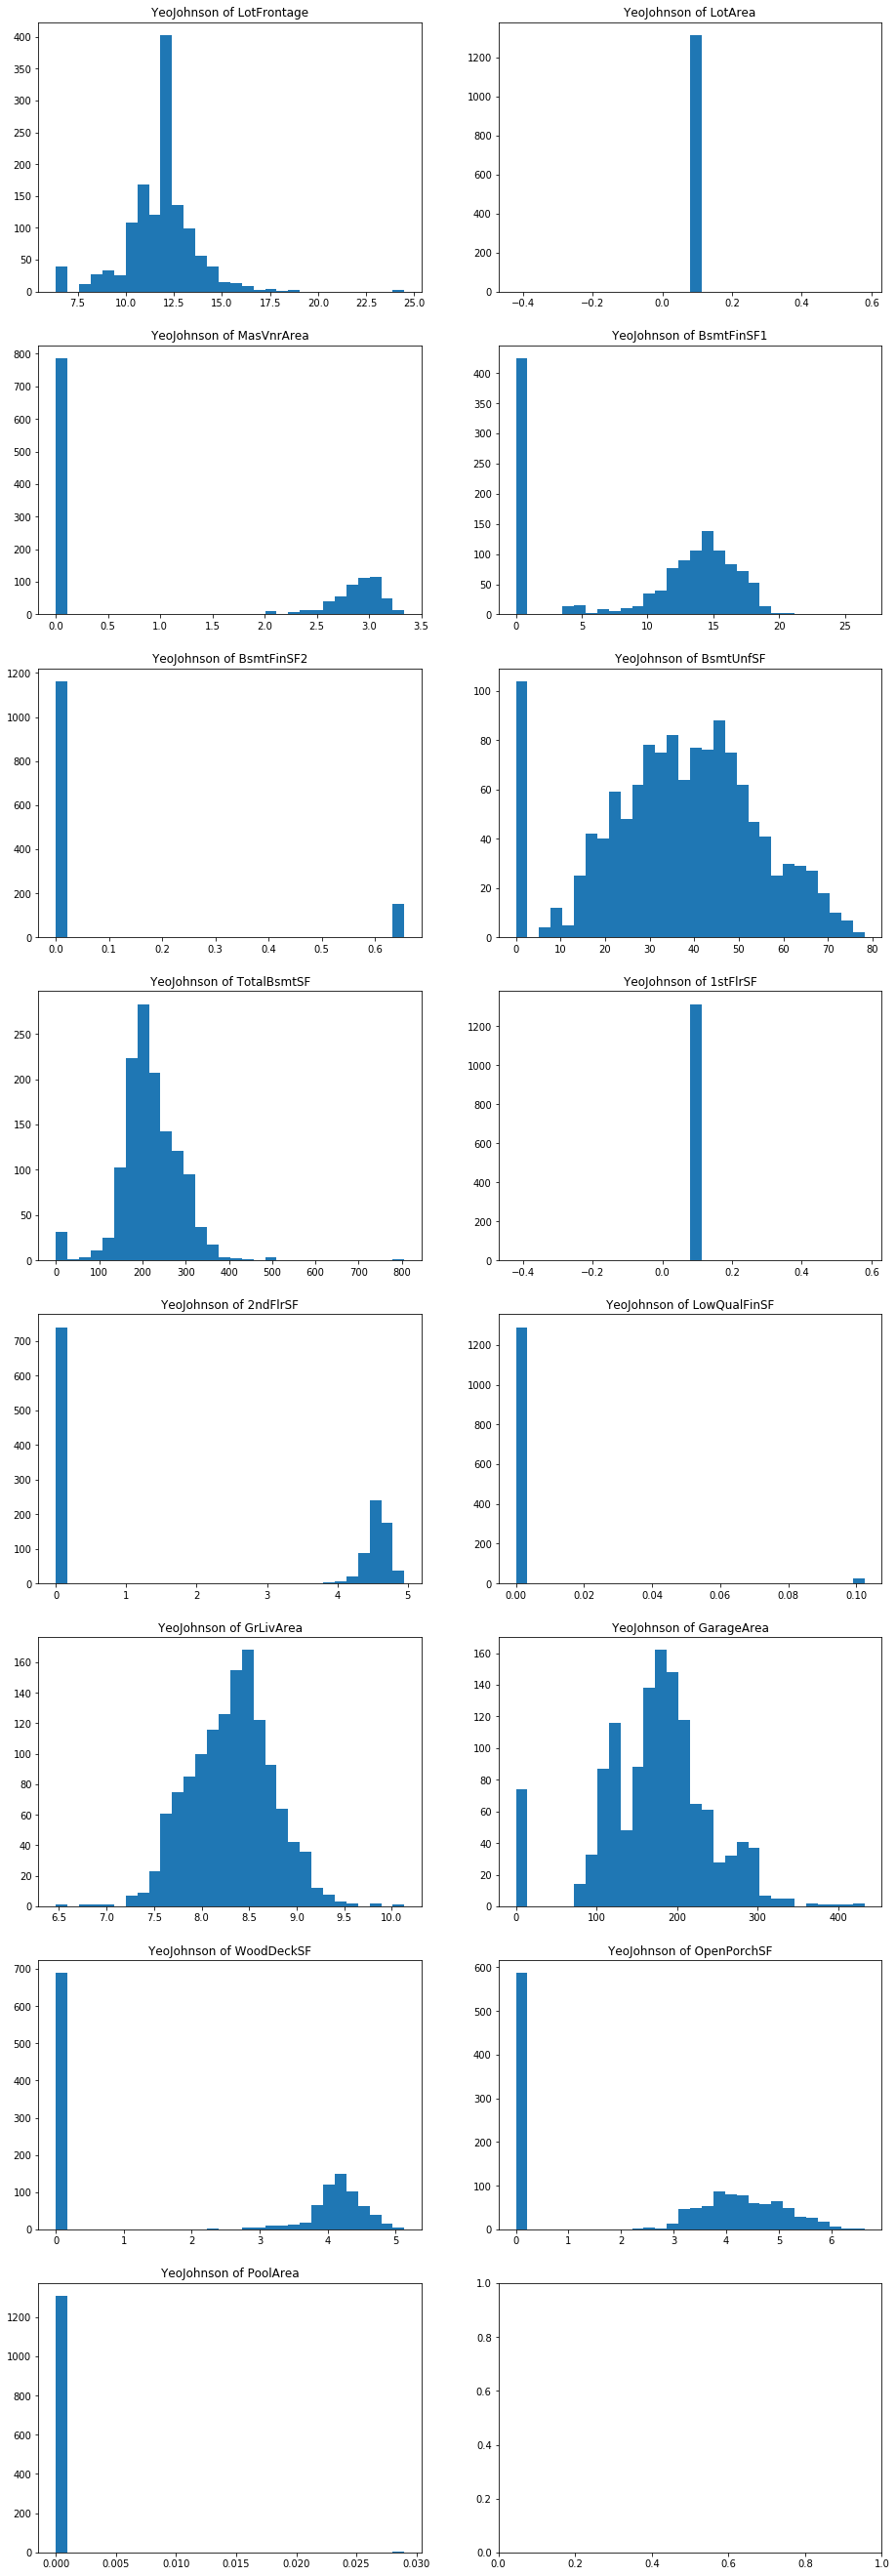

In [54]:
# plot training data to examine new distributions for area cols

if len(area_cols)%2==0:
    nrows=len(area_cols)//2
else:
    nrows=len(area_cols)//2 + 1
    
fig, axes = plt.subplots(nrows,2, figsize=(15,45))
row=0 
col=0
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

for column in area_cols:
    
    axes[row,col].hist(X_train_imp_tr[column], bins=30)
    axes[row,col].set_title("YeoJohnson of "+column)
   
    
    if col==0:
        col=col+1
        
    else:
        row=row+1
        col=0

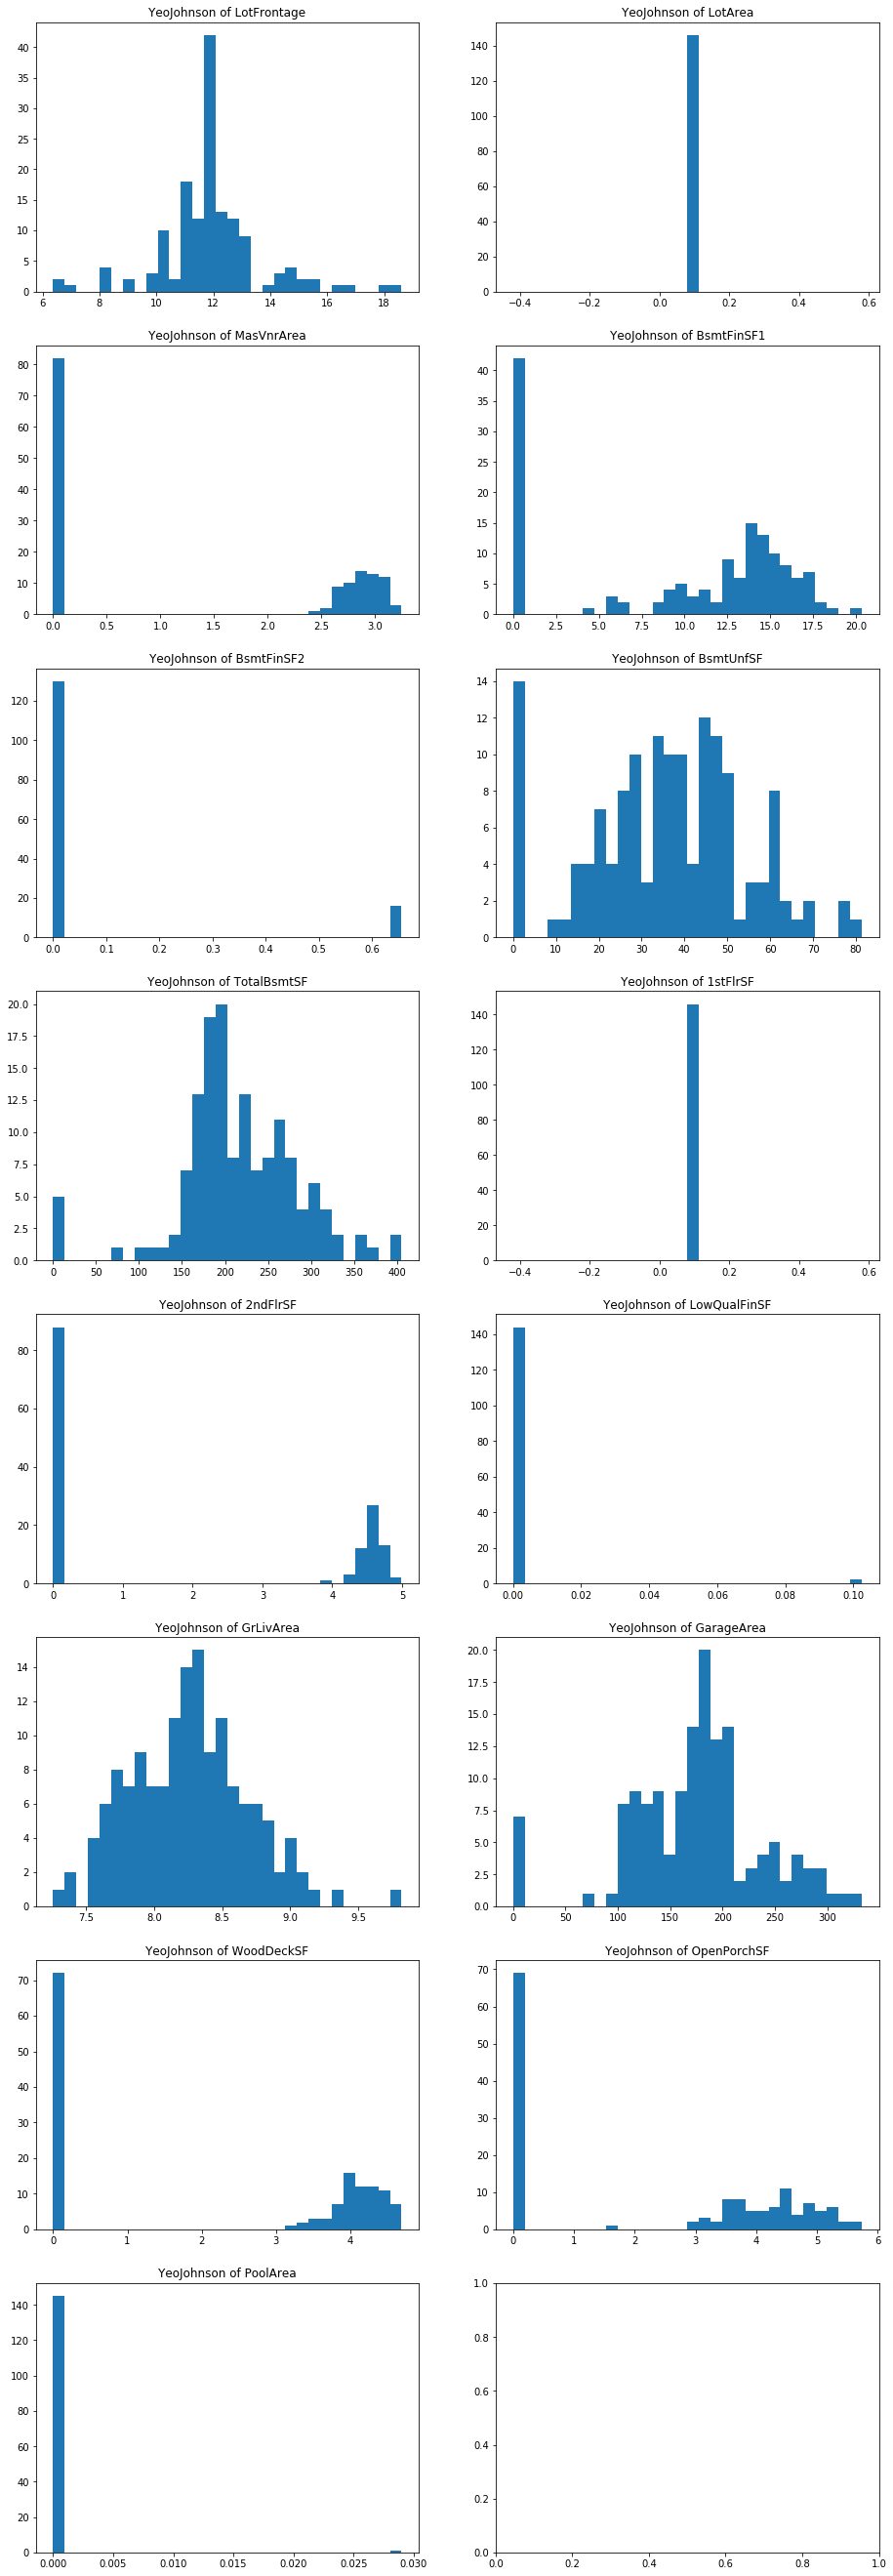

In [55]:
if len(area_cols)%2==0:
    nrows=len(area_cols)//2
else:
    nrows=len(area_cols)//2 + 1
    
fig, axes = plt.subplots(nrows,2, figsize=(15,45))
row=0 
col=0
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

for column in area_cols:
    
    axes[row,col].hist(X_test_imp_tr[column], bins=30)
    axes[row,col].set_title("YeoJohnson of "+column)
   
    
    if col==0:
        col=col+1
        
    else:
        row=row+1
        col=0

In [56]:
# step 3: scaling the features since we will be using LR

scaler = StandardScaler()
scaler.fit(X_train_imp_tr)

# transform 
X_train_imp_sc = scaler.transform(X_train_imp_tr)
X_test_imp_sc = scaler.transform(X_test_imp_tr)

In [60]:
# step4: make predictions and evaluate model using R2 and RMSE

lr = LinearRegression()
lr.fit(X_train_imp_sc, y_train)

y_pred_train = lr.predict(X_train_imp_sc)
y_pred_test = lr.predict(X_test_imp_sc)

In [76]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, y_pred_train)))
print('train rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('train r2: {}'.format(r2_score(y_train, y_pred_train)))
#print('train rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_train), np.log(y_pred_train)))))
print()
print('test mse: {}'.format(mean_squared_error(y_test, y_pred_test)))
print('test rmsle: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
print('test rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_test)))))
print('test r2: {}'.format(r2_score(y_test, y_pred_test)))

train mse: 1263498011.4684067
train rmse: 35545.71720289811
train r2: 0.7976406097338631

test mse: 1859589230.591031
test rmsle: 43122.95479893546
test rmsle: 0.2011846155448954
test r2: 0.7294007517301734


Text(0, 0.5, 'Predicted Price')

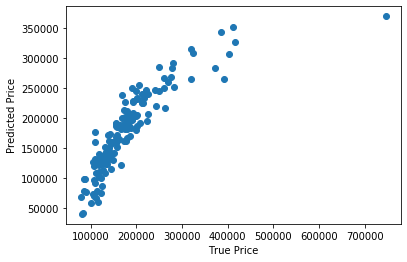

In [68]:
# plot predictions vs real value

plt.scatter(y_test,y_pred_test)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

In [77]:
# use a lightgbm regression to quick compare

lightgbm_regr = LGBMRegressor()

lightgbm_regr.fit(X_train_imp_sc, y_train)

y_pred_train = lightgbm_regr.predict(X_train_imp_sc)
y_pred_test = lightgbm_regr.predict(X_test_imp_sc)

In [78]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, y_pred_train)))
print('train rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('train r2: {}'.format(r2_score(y_train, y_pred_train)))
#print('train rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_train), np.log(y_pred_train)))))
print()
print('test mse: {}'.format(mean_squared_error(y_test, y_pred_test)))
print('test rmse: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
print('test rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_test)))))
print('test r2: {}'.format(r2_score(y_test, y_pred_test)))

train mse: 180280413.54306397
train rmse: 13426.854193855834
train r2: 0.9711266387201484

test mse: 1240879785.0402377
test rmsle: 35226.123616433266
test rmsle: 0.1391042892975643
test r2: 0.8194326297972852


**Conclusion:**
The above model is a good starting point that can be enhanced in several directions including:

1. Lightgbm regression has a much better performance but need regularization because of overfitting
2. Add encoded categorical variables to the model
3. Add engineered features from years_columns
4. Remove extreme outlier rows from training
